Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [ ]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import os
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt
%matplotlib inline

/Users/Summit/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
data_root = './support_data'
# pickle_file = os.path.join(data_root, 'notMNIST.pickle')
pickle_file = os.path.join(data_root, 'notMNIST_clean.pickle')



with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (195125, 28, 28) (195125,)
Validation set (9828, 28, 28) (9828,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (195125, 784) (195125, 10)
Validation set (9828, 784) (9828, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

Minibatch loss at step 0: 635.224121
Minibatch accuracy: 10.2%
Validation accuracy: 32.0%
Minibatch loss at step 500: 193.359467
Minibatch accuracy: 86.7%
Validation accuracy: 80.9%
Minibatch loss at step 1000: 115.385483
Minibatch accuracy: 81.2%
Validation accuracy: 81.2%
Minibatch loss at step 1500: 69.145660
Minibatch accuracy: 77.3%
Validation accuracy: 82.4%
Minibatch loss at step 2000: 41.734482
Minibatch accuracy: 84.4%
Validation accuracy: 84.3%
Minibatch loss at step 2500: 25.266275
Minibatch accuracy: 89.8%
Validation accuracy: 85.8%
Minibatch loss at step 3000: 15.337799
Minibatch accuracy: 90.6%
Validation accuracy: 87.0%
Test accuracy: 93.0%


Text(0.5,1,'accuracty')

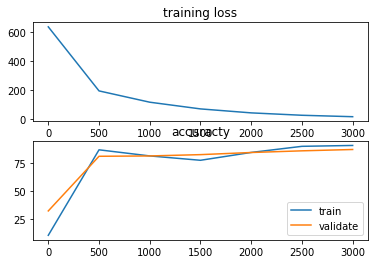

In [5]:
# write the computational graph from scrach
size_batch = 128
M_X = train_dataset.shape[1]
M_H = 1024
M_Y = train_labels.shape[1]
lambda_l2 = 0.001


# first, we need a grpah
graph = tf.Graph()
with graph.as_default():
    # input data
    X_tr = tf.placeholder(dtype=tf.float32, shape=[size_batch, M_X]) # alarm: use placeholder, but not variable
    Y_tr = tf.placeholder(dtype=tf.float32, shape=[size_batch, M_Y])
    X_vl = tf.constant(valid_dataset)
    X_ts = tf.constant(test_dataset)
    
    # variables to train
    W0 = tf.Variable(tf.truncated_normal([M_X, M_H]))  # alarm: initilize them
    b0 = tf.Variable(tf.zeros([M_H]))
    W1 = tf.Variable(tf.truncated_normal([M_H, M_Y]))
    b1 = tf.Variable(tf.zeros([M_Y]))
    
    # loss
    H = tf.nn.relu(tf.matmul(X_tr, W0) + b0)        # alarm: use matrix multiply
    logits = tf.matmul(H, W1) + b1
    #loss = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y_tr) ) # original
    loss = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y_tr) ) + lambda_l2*(tf.nn.l2_loss(W0)+tf.nn.l2_loss(W1))
                     
    # optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)   # give oprimizer a name
    
    # model preditction
    Y_tr_hat = tf.nn.softmax(logits)
    Y_vl_hat = tf.nn.softmax( tf.matmul(tf.nn.relu(tf.matmul(X_vl, W0) + b0), W1) + b1 )
    Y_ts_hat = tf.nn.softmax( tf.matmul(tf.nn.relu(tf.matmul(X_ts, W0) + b0), W1) + b1 )
    
# next, we need a session
num_steps = 3001
step_plot = []
acc_tr = []
acc_vl = []
loss_tr = []
                     
with tf.Session(graph=graph) as session:
    # initilize variables
    tf.global_variables_initializer().run()
     
    # loop
    for step in range(num_steps):
        # get batch data
        offset = (step * size_batch) % (train_dataset.shape[0] - size_batch)
        X_batch = train_dataset[offset:offset+size_batch, :]
        Y_batch = train_labels[offset:offset+size_batch, :]
        feed_dict = {X_tr: X_batch, Y_tr: Y_batch}
        [_, l, predictions] = session.run([optimizer, loss, Y_tr_hat], feed_dict= feed_dict)
        if (step % 500 == 0):
            step_plot.append(step)
            loss_tr.append(l)
            acc_tr.append(accuracy(predictions, Y_batch))
            acc_vl.append(accuracy(Y_vl_hat.eval(), valid_labels))
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, Y_batch))
            print("Validation accuracy: %.1f%%" % accuracy(Y_vl_hat.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(Y_ts_hat.eval(), test_labels))

# plot
plt.subplot(2,1,1)
plt.plot(step_plot, loss_tr)
plt.title('training loss')
plt.subplot(2,1,2)
plt.plot(step_plot, acc_tr)
plt.plot(step_plot, acc_vl)
plt.legend(['train','validate'])
plt.title('accuracty')

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

Minibatch loss at step 0: 347.104248
Minibatch accuracy: 10.9%
Validation accuracy: 31.6%
Minibatch loss at step 500: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 65.5%
Minibatch loss at step 1000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 65.5%
Minibatch loss at step 1500: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 65.5%
Minibatch loss at step 2000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 65.5%
Minibatch loss at step 2500: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 65.5%
Minibatch loss at step 3000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 65.5%
Test accuracy: 73.4%


Text(0.5,1,'accuracty')

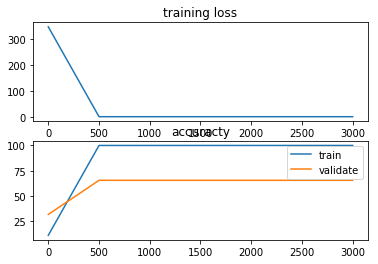

In [6]:
# write the computational graph from scrach
size_batch = 128
M_X = train_dataset.shape[1]
M_H = 1024
M_Y = train_labels.shape[1]
lambda_l2 = 0.000


# first, we need a grpah
graph = tf.Graph()
with graph.as_default():
    # input data
    X_tr = tf.placeholder(dtype=tf.float32, shape=[size_batch, M_X]) # alarm: use placeholder, but not variable
    Y_tr = tf.placeholder(dtype=tf.float32, shape=[size_batch, M_Y])
    X_vl = tf.constant(valid_dataset)
    X_ts = tf.constant(test_dataset)
    
    # variables to train
    W0 = tf.Variable(tf.truncated_normal([M_X, M_H]))  # alarm: initilize them
    b0 = tf.Variable(tf.zeros([M_H]))
    W1 = tf.Variable(tf.truncated_normal([M_H, M_Y]))
    b1 = tf.Variable(tf.zeros([M_Y]))
    
    # loss
    H = tf.nn.relu(tf.matmul(X_tr, W0) + b0)        # alarm: use matrix multiply
    logits = tf.matmul(H, W1) + b1
    #loss = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y_tr) ) # original
    loss = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y_tr) ) \
    + lambda_l2*(tf.nn.l2_loss(W0)+tf.nn.l2_loss(W1))
                     
    # optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)   # give oprimizer a name
    
    # model preditction
    Y_tr_hat = tf.nn.softmax(logits)
    Y_vl_hat = tf.nn.softmax( tf.matmul(tf.nn.relu(tf.matmul(X_vl, W0) + b0), W1) + b1 )
    Y_ts_hat = tf.nn.softmax( tf.matmul(tf.nn.relu(tf.matmul(X_ts, W0) + b0), W1) + b1 )
    
# next, we need a session
num_steps = 3001
step_plot = []
acc_tr = []
acc_vl = []
loss_tr = []
                     
with tf.Session(graph=graph) as session:
    # initilize variables
    tf.global_variables_initializer().run()
     
    # loop
    for step in range(num_steps):
        # get batch data
        offset = (step * size_batch) % (256 - size_batch)
        X_batch = train_dataset[offset:offset+size_batch, :]
        Y_batch = train_labels[offset:offset+size_batch, :]
        feed_dict = {X_tr: X_batch, Y_tr: Y_batch}
        [_, l, predictions] = session.run([optimizer, loss, Y_tr_hat], feed_dict= feed_dict)
        if (step % 500 == 0):
            step_plot.append(step)
            loss_tr.append(l)
            acc_tr.append(accuracy(predictions, Y_batch))
            acc_vl.append(accuracy(Y_vl_hat.eval(), valid_labels))
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, Y_batch))
            print("Validation accuracy: %.1f%%" % accuracy(Y_vl_hat.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(Y_ts_hat.eval(), test_labels))

# plot
plt.subplot(2,1,1)
plt.plot(step_plot, loss_tr)
plt.title('training loss')
plt.subplot(2,1,2)
plt.plot(step_plot, acc_tr)
plt.plot(step_plot, acc_vl)
plt.legend(['train','validate'])
plt.title('accuracty')

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

Minibatch loss at step 0: 769.869446
Minibatch accuracy: 9.4%
Validation accuracy: 41.7%
Minibatch loss at step 500: 192.101837
Minibatch accuracy: 100.0%
Validation accuracy: 76.2%
Minibatch loss at step 1000: 116.556602
Minibatch accuracy: 100.0%
Validation accuracy: 76.7%
Minibatch loss at step 1500: 70.767479
Minibatch accuracy: 99.2%
Validation accuracy: 76.5%
Minibatch loss at step 2000: 42.892082
Minibatch accuracy: 100.0%
Validation accuracy: 76.9%
Minibatch loss at step 2500: 26.014347
Minibatch accuracy: 100.0%
Validation accuracy: 77.0%
Minibatch loss at step 3000: 15.777221
Minibatch accuracy: 100.0%
Validation accuracy: 77.1%
Test accuracy: 84.7%


Text(0.5,1,'accuracty')

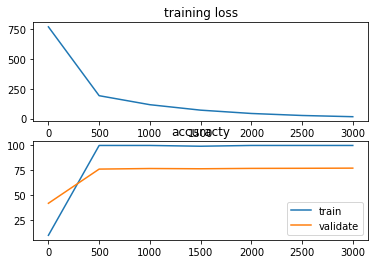

In [9]:
# write the computational graph from scrach
size_batch = 128
M_X = train_dataset.shape[1]
M_H = 1024
M_Y = train_labels.shape[1]
lambda_l2 = 0.001


# first, we need a grpah
graph = tf.Graph()
with graph.as_default():
    # input data
    X_tr = tf.placeholder(dtype=tf.float32, shape=[size_batch, M_X]) # alarm: use placeholder, but not variable
    Y_tr = tf.placeholder(dtype=tf.float32, shape=[size_batch, M_Y])
    X_vl = tf.constant(valid_dataset)
    X_ts = tf.constant(test_dataset)
    
    # variables to train
    W0 = tf.Variable(tf.truncated_normal([M_X, M_H]))  # alarm: initilize them
    b0 = tf.Variable(tf.zeros([M_H]))
    W1 = tf.Variable(tf.truncated_normal([M_H, M_Y]))
    b1 = tf.Variable(tf.zeros([M_Y]))
    
    # loss
    H = tf.nn.dropout(tf.nn.relu(tf.matmul(X_tr, W0) + b0), keep_prob=0.5)        # alarm: use matrix multiply
    logits = tf.matmul(H, W1) + b1
    #loss = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y_tr) ) # original
    loss = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y_tr) ) \
    + lambda_l2*(tf.nn.l2_loss(W0)+tf.nn.l2_loss(W1))
                     
    # optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)   # give oprimizer a name
    
    # model preditction
    Y_tr_hat = tf.nn.softmax(logits)
    Y_vl_hat = tf.nn.softmax( tf.matmul(tf.nn.relu(tf.matmul(X_vl, W0) + b0), W1) + b1 )
    Y_ts_hat = tf.nn.softmax( tf.matmul(tf.nn.relu(tf.matmul(X_ts, W0) + b0), W1) + b1 )
    
# next, we need a session
num_steps = 3001
step_plot = []
acc_tr = []
acc_vl = []
loss_tr = []
                     
with tf.Session(graph=graph) as session:
    # initilize variables
    tf.global_variables_initializer().run()
     
    # loop
    for step in range(num_steps):
        # get batch data
        offset = (step * size_batch) % (512 - size_batch)
        X_batch = train_dataset[offset:offset+size_batch, :]
        Y_batch = train_labels[offset:offset+size_batch, :]
        feed_dict = {X_tr: X_batch, Y_tr: Y_batch}
        [_, l, predictions] = session.run([optimizer, loss, Y_tr_hat], feed_dict= feed_dict)
        if (step % 500 == 0):
            step_plot.append(step)
            loss_tr.append(l)
            acc_tr.append(accuracy(predictions, Y_batch))
            acc_vl.append(accuracy(Y_vl_hat.eval(), valid_labels))
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, Y_batch))
            print("Validation accuracy: %.1f%%" % accuracy(Y_vl_hat.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(Y_ts_hat.eval(), test_labels))

# plot
plt.subplot(2,1,1)
plt.plot(step_plot, loss_tr)
plt.title('training loss')
plt.subplot(2,1,2)
plt.plot(step_plot, acc_tr)
plt.plot(step_plot, acc_vl)
plt.legend(['train','validate'])
plt.title('accuracty')

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


Minibatch loss at step 0: 2.780353
Minibatch accuracy: 10.2%
Validation accuracy: 16.0%
Minibatch loss at step 500: 1.042755
Minibatch accuracy: 83.2%
Validation accuracy: 83.8%
Minibatch loss at step 1000: 0.930597
Minibatch accuracy: 83.2%
Validation accuracy: 84.9%
Minibatch loss at step 1500: 0.915674
Minibatch accuracy: 85.5%
Validation accuracy: 85.9%
Minibatch loss at step 2000: 0.749646
Minibatch accuracy: 88.7%
Validation accuracy: 86.3%
Minibatch loss at step 2500: 0.820508
Minibatch accuracy: 85.2%
Validation accuracy: 87.0%
Minibatch loss at step 3000: 0.771640
Minibatch accuracy: 84.0%
Validation accuracy: 87.2%
Minibatch loss at step 3500: 0.582772
Minibatch accuracy: 89.8%
Validation accuracy: 87.5%
Minibatch loss at step 4000: 0.663232
Minibatch accuracy: 86.7%
Validation accuracy: 87.9%
Minibatch loss at step 4500: 0.584788
Minibatch accuracy: 89.8%
Validation accuracy: 88.3%
Minibatch loss at step 5000: 0.581499
Minibatch accuracy: 89.8%
Validation accuracy: 88.3%
Min

Text(0.5,1,'accuracty')

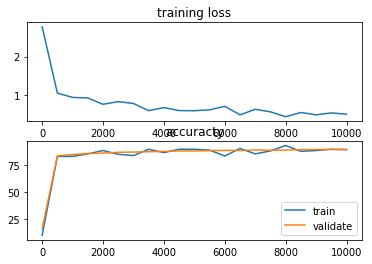

In [15]:
# write the computational graph from scrach
size_batch = 256
M_X = train_dataset.shape[1]
M_H0 = 512
M_H1 = 128
M_Y = train_labels.shape[1]
lambda_l2 = 0.001


# first, we need a grpah
graph = tf.Graph()
with graph.as_default():
    # input data
    X_tr = tf.placeholder(dtype=tf.float32, shape=[size_batch, M_X]) # alarm: use placeholder, but not variable
    Y_tr = tf.placeholder(dtype=tf.float32, shape=[size_batch, M_Y])
    X_vl = tf.constant(valid_dataset)
    X_ts = tf.constant(test_dataset)
    
    # variables to train
    W0 = tf.Variable(tf.truncated_normal([M_X, M_H0], stddev=0.05))  # alarm: initilize them, make stddev small
    b0 = tf.Variable(tf.zeros([M_H0]))
    W1 = tf.Variable(tf.truncated_normal([M_H0, M_H1] , stddev=0.05))
    b1 = tf.Variable(tf.zeros([M_H1]))
    W2 = tf.Variable(tf.truncated_normal([M_H1, M_Y], stddev=0.05))
    b2 = tf.Variable(tf.zeros([M_Y]))
    
    # loss
    H0 = tf.nn.dropout(tf.nn.relu(tf.matmul(X_tr, W0) + b0), keep_prob=0.7)        # alarm: use matrix multiply
    H1 = tf.nn.dropout(tf.nn.relu(tf.matmul(H0, W1) + b1), keep_prob=0.7)        # alarm: use matrix multiply
    logits = tf.matmul(H1, W2) + b2
    #loss = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y_tr) ) # original
    loss = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y_tr) ) \
    + lambda_l2*(tf.nn.l2_loss(W0)+tf.nn.l2_loss(W1)+tf.nn.l2_loss(W2))
                     
    # optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)   # give oprimizer a name
    
    # model preditction
    Y_tr_hat = tf.nn.softmax(logits)
    Y_vl_hat = tf.nn.softmax( tf.matmul(tf.nn.relu(tf.matmul(tf.nn.relu(tf.matmul(X_vl, W0) + b0), W1) + b1), W2) + b2)
    Y_ts_hat = tf.nn.softmax( tf.matmul(tf.nn.relu(tf.matmul(tf.nn.relu(tf.matmul(X_ts, W0) + b0), W1) + b1), W2) + b2)
    
# next, we need a session
num_steps = 10001
step_plot = []
acc_tr = []
acc_vl = []
loss_tr = []
                     
with tf.Session(graph=graph) as session:
    # initilize variables
    tf.global_variables_initializer().run()
     
    # loop
    for step in range(num_steps):
        # get batch data
        offset = (step * size_batch) % (train_dataset.shape[0] - size_batch)
        X_batch = train_dataset[offset:offset+size_batch, :]
        Y_batch = train_labels[offset:offset+size_batch, :]
        feed_dict = {X_tr: X_batch, Y_tr: Y_batch}
        [_, l, predictions] = session.run([optimizer, loss, Y_tr_hat], feed_dict= feed_dict)
        if (step % 500 == 0):
            step_plot.append(step)
            loss_tr.append(l)
            acc_tr.append(accuracy(predictions, Y_batch))
            acc_vl.append(accuracy(Y_vl_hat.eval(), valid_labels))
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, Y_batch))
            print("Validation accuracy: %.1f%%" % accuracy(Y_vl_hat.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(Y_ts_hat.eval(), test_labels))

# plot
plt.subplot(2,1,1)
plt.plot(step_plot, loss_tr)
plt.title('training loss')
plt.subplot(2,1,2)
plt.plot(step_plot, acc_tr)
plt.plot(step_plot, acc_vl)
plt.legend(['train','validate'])
plt.title('accuracty')